## Script type classification

#### Imports and constants

In [ ]:
!wget --no-cache --no-cookies "https://raw.githubusercontent.com/vishnu-dev/icdar-semi-supervised-learning/main/requirements.txt" -O requirements.txt && pip install -q -r requirements.txt

In [26]:
# Common imports
import os
import glob
import torch
import shutil
import numpy as np
import pandas as pd
from PIL import Image
import pytorch_lightning as pl
from sklearn.manifold import TSNE
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from pl_bolts.models.self_supervised import SimCLR
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from pl_bolts.models.self_supervised.simclr.transforms import SimCLRTrainDataTransform, SimCLREvalDataTransform
from pl_bolts.utils.stability import UnderReviewWarning
from sklearn.neighbors import KNeighborsClassifier
from torch.nn.functional import cross_entropy
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import plotly.express as px
import torchvision
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

NUM_WORKERS = os.cpu_count()

# Setting the seed
pl.seed_everything(42)

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)
print("Number of workers:", NUM_WORKERS)

Global seed set to 42


Device: cuda:0
Number of workers: 8


In [11]:
proj_dir = '/home/uj43ugat/icdar/'

data_dir = os.path.join(
    proj_dir,
    'data/ICDAR2017_CLaMM_Training'
)

label_file_path = os.path.join(
    data_dir,
    '@ICDAR2017_CLaMM_Training.csv'
)

font_group_map = {1: 'Caroline', 2: 'Cursiva', 3: 'Half-Uncial', 4: 'Humanistic', 5: 'Humanistic Cursive', 6: 'Hybrida', 7: 'Praegothica', 8: 'Semihybrida', 9: 'Semitextualis', 10: 'Southern Textualis', 11: 'Textualis', 12: 'Uncial'}

#### Dataset

In [12]:
class ICDARDataset(Dataset):

    def __init__(self, csv_filepath, root_dir, transforms=None):
        self.root_dir = root_dir
        self.transforms = transforms
        self.data = pd.read_csv(csv_filepath, sep=';')

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = os.path.join(self.root_dir, self.data.loc[idx, 'FILENAME'])
        try:
            image = Image.open(img_path)
        except Exception as ex:
            return None
        image = image.convert('RGB')

        if self.transforms is not None:
            image = self.transforms(image)

        return image, self.data.loc[idx, 'SCRIPT_TYPE']

In [13]:
im, label = ICDARDataset(label_file_path, data_dir, SimCLRTrainDataTransform())[0]
print(im[0].shape)

torch.Size([3, 224, 224])


#### Data pre-processing

In [14]:
train_dataset = ICDARDataset(label_file_path, data_dir, transforms=SimCLRTrainDataTransform())
val_dataset = ICDARDataset(label_file_path, data_dir, transforms=SimCLREvalDataTransform())

In [15]:
def custom_collate(batch):
    batch = list(filter(lambda x: x is not None, batch))
    return torch.utils.data.dataloader.default_collate(batch)

### Modeling
#### SimCLR

In [16]:
def train_simclr(batch_size, max_epochs=500, **kwargs):
    trainer = pl.Trainer(
        default_root_dir=os.path.join(proj_dir, 'SimCLR'),
        accelerator='gpu',
        devices=-1,
        max_epochs=max_epochs,
        callbacks=[
            ModelCheckpoint(save_weights_only=True, mode='min', monitor='val_loss')
        ],
        enable_progress_bar=True,
        precision=16
    )

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(proj_dir, 'SimCLR.ckpt')
    if os.path.isfile(pretrained_filename):
        print(f'Found pretrained model at {pretrained_filename}, loading...')
        # Automatically loads the model with the saved hyperparameters
        simclr = SimCLR.load_from_checkpoint(pretrained_filename)
    else:
        train_loader = DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True,
            drop_last=True,
            pin_memory=True,
            num_workers=NUM_WORKERS,
        )
        val_loader = DataLoader(
            val_dataset,
            batch_size=batch_size,
            shuffle=False,
            drop_last=False,
            pin_memory=True,
            num_workers=NUM_WORKERS,
        )
        simclr = SimCLR(max_epochs=max_epochs, batch_size=batch_size, **kwargs)
        simclr.cuda()
        trainer.fit(simclr, train_loader, val_loader)
        # Load the best checkpoint after training
        simclr = SimCLR.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    return simclr

In [17]:
model = train_simclr(
    64,
    max_epochs=150,
    gpus=-1,
    num_samples=len(train_dataset),
    dataset='icdar'
)

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | encoder    | ResNet     | 25.6 M
1 | projection | Projection | 4.5 M 
------------------------------------------
30.0 M    Trainable params
0         Non-trainable params
30.0 M    Total params
60.039    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

IsADirectoryError: [Errno 21] Is a directory: '/home/uj43ugat/code/icdar-semi-supervised-learning'

In [18]:
def plot_features(model, data_loader, num_classes, num_feats, batch_size, num_samples):

    num_samples = len(data_loader) if not num_samples else num_samples
    feats = np.array([]).reshape((0,num_feats))
    labels = np.array([])
    model.eval()
    model.cuda()

    processed_samples = 0
    with torch.no_grad():
        for (x1, x2, _), label in tqdm(data_loader):
            if processed_samples >= num_samples:
                break
            x1 = x1.squeeze().cuda()
            out = model(x1)
            out = out.cpu().data.numpy()
            feats = np.append(feats, out, axis=0)
            labels = np.append(labels, label, axis=0)
            processed_samples += batch_size


    tsne = TSNE(n_components=3, perplexity=40, init='pca')
    x_feats = tsne.fit_transform(feats)
    print(x_feats.shape, labels.shape)

    dim_red_df = pd.DataFrame(x_feats)
    dim_red_df['labels'] = pd.Categorical(labels)
    fig = px.scatter_3d(dim_red_df, x=0, y=1, z=2, color='labels')
    fig.show()


In [21]:
val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    drop_last=True,
    pin_memory=True,
    num_workers=NUM_WORKERS,
)

checkpoint = os.path.join(
    proj_dir,
    'SimCLR/lightning_logs/version_7/checkpoints/epoch=141-step=7810.ckpt'
)

simclr_trained = SimCLR.load_from_checkpoint(checkpoint)
plot_features(simclr_trained, val_loader, len(font_group_map), 2048, 32, 1000)

  0%|          | 0/110 [00:00<?, ?it/s]

(1024, 3) (1024,)


In [20]:
def finetune(model, epochs=50):
    train_loader = DataLoader(
        train_dataset,
        batch_size=64,
        shuffle=True,
        drop_last=True,
        pin_memory=True,
        num_workers=NUM_WORKERS,
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=64,
        shuffle=False,
        drop_last=True,
        pin_memory=True,
        num_workers=NUM_WORKERS,
    )
    
    model.eval()
    model.cuda()
    embeddings = np.array([]).reshape((0, 2048))
    labels = np.array([])
    
    neigh = KNeighborsClassifier(n_neighbors=5)
    resnet50 = model.encoder

    for (x1, x2, _), label in tqdm(train_loader):
        x1 = x1.squeeze().cuda()
        out = model.forward(x1)
        out = out.cpu().data.numpy()
        embeddings = np.append(embeddings, out, axis=0)
        labels = np.append(labels, label, axis=0)
    
    neigh.fit(embeddings, labels)
    
    del embeddings
    
    with torch.no_grad():
        for epoch in range(epochs):
            acc_epoch = []
            for (x1, x2, _), label in val_loader:
                x1 = x1.squeeze().cuda()
                feats = resnet50(x1)
                feats = np.array([feat.cpu().data.numpy() for feat in feats])
                y_hat = neigh.predict(feats[0])
                acc = accuracy_score(torch.from_numpy(y_hat), label)
                acc_epoch.append(acc)
            print(epoch, np.mean(acc_epoch))

            if epoch == 10:
                resnet50.unfreeze()
    
    return resnet50
    

In [ ]:
simclr_tuned = finetune(simclr_trained, 20)

### Masked Autoencoders

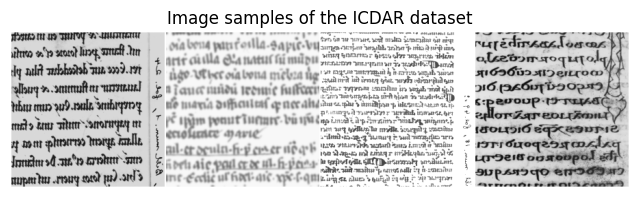

In [51]:
NUM_IMAGES = 4
icdar_images = torch.stack([val_dataset[idx][0][0] for idx in range(NUM_IMAGES)], dim=0)
img_grid = torchvision.utils.make_grid(icdar_images, nrow=4, normalize=True, pad_value=1)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8, 8))
plt.title("Image samples of the ICDAR dataset")
plt.imshow(img_grid)
plt.axis("off")
plt.show()
plt.close()

In [54]:
def img_to_patch(x, patch_size, flatten_channels=True):
    B, C, H, W = x.shape
    print(B, C, H, W)
    x = x.reshape(B, C, H // patch_size, patch_size, W // patch_size, patch_size)
    x = x.permute(0, 2, 4, 1, 3, 5)  # [B, H', W', C, p_H, p_W]
    x = x.flatten(1, 2)  # [B, H'*W', C, p_H, p_W]
    if flatten_channels:
        x = x.flatten(2, 4)  # [B, H'*W', C*p_H*p_W]
    return x

4 3 224 224


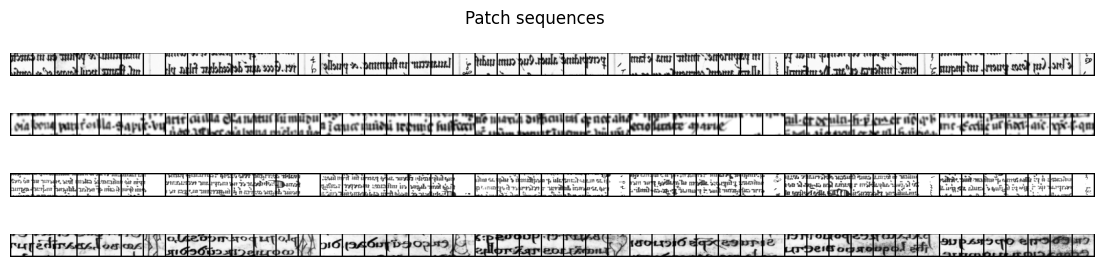

In [69]:
img_patches = img_to_patch(icdar_images, patch_size=32, flatten_channels=False)

fig, ax = plt.subplots(icdar_images.shape[0], 1, figsize=(14, 3))
fig.suptitle("Patch sequences")
for i in range(icdar_images.shape[0]):
    img_grid = torchvision.utils.make_grid(img_patches[i], nrow=64, normalize=True, pad_value=0)
    img_grid = img_grid.permute(1, 2, 0)
    ax[i].imshow(img_grid)
    ax[i].axis("off")
plt.show()
plt.close()